In [1]:
#General
import re
import sys
import pprint
import seaborn as sb
import numpy   as np
import pandas  as pd
import random  as rnd

from bios    import read
from os.path import isfile
from copy    import deepcopy
from time    import time
from tqdm    import tqdm
from getdist import plots

from scipy.interpolate import interp1d
from scipy.stats       import multivariate_normal
from itertools         import repeat

from getdist import plots,loadMCSamples,MCSamples

from theory_code.distance_theory import TheoryCalcs

#Plotting
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import rc

rc('text', usetex=True)
rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 18})

red    = '#8e001c'
yellow = '#ffb302'

sidelegend = {'bbox_to_anchor': (1.04,0.5), 
              'loc': "center left",
              'frameon': False}
bottomlegend = {'bbox_to_anchor': (0.35,-0.2), 
                'loc': "center left",
                'frameon': False,
                'ncols': 3}

# Settings

In [2]:
DESI_LCDM = {'omegam': 0.2948,
             'H0': 68.53,
             'epsilon0_EM': 0.1}

fiducial = {'H0': 68.53,
            'omegam': 0.2948,
            'ombh2': 0.02218,
            'epsilon0_EM': 0.1,
            'epsilon0_GW': -0.1,
            'omk': 0.,
            'mnu': 0.06,
            'nnu': 3.,
            'MB': -19.2435}

theory_settings = {'zmin': 0.001,
                   'zmax': 5.,
                   'Nz': 1000,
                   'zdrag': 1060,
                   'm1': 1.4,
                   'm2': 1.4}

zplot = np.linspace(0.01,3,100)

BAO_data = './data/DESI'
SN_data  = './data/Pantheon'
GW_data = './mock_data/GW_mock_data'

In [3]:
results = {r'$\Lambda$CDM': {r'DESI': {'root': './chains/DESI_LCDM',
                                       'sampler': 'MH',
                                       'DDR_model': 'constant',
                                       'Nchains': 4,
                                       'color': red,
                                       'filled': True},
                             r'Pantheon+$M_B$': {'root': './chains/Pantheon_LCDM',
                                                 'sampler': 'MH',
                                                 'DDR_model': 'constant',
                                                 'color': 'purple',
                                                 'Nchains': 4,
                                                 'filled': True},
                             #r'DESI+Pantheon+$M_B$': {'root': './chains/DESI_Pantheon_LCDM',
                             #                         'sampler': 'MH',
                             #                         'DDR_model': 'constant',
                             #                         'color': 'black',
                             #                         'Nchains': 4,
                             #                         'filled': True},
                            }
                               
          }

# Analysis

In [4]:
def analyze_results(name,info):
    analysis = deepcopy(info)
    
    print('')
    print('\x1b[1;31m Analyzing {} \x1b[0m'.format(name))
    
    chain_info = deepcopy(info)
    if info['sampler'] == 'MH':
        sample = loadMCSamples(info['root'], settings={'ignore_rows': 0.3})
    
        if info['Nchains']>1:
            print('R-1({}) with {:.0f}% of points ignored = {:.3f}'.format(name,30,
                                                                           sample.getGelmanRubin()))
        else:
            print('Single chain, no R-1 computed. Trust Cobaya and hope for the best')
            
        columns = open(info['root']+'.1.txt').readline().rstrip().split()
        columns.pop(0)    
        chains = []
        for ch in range(info['Nchains']):
            chains.append(pd.read_csv(info['root']+'.{}.txt'.format(ch+1),
                                      sep='\s+',skiprows=1,header=None,names=columns))
            
        for par in ['omegam','H0']:
            plt.figure()
            plt.title(name)
            for chain in chains:
                plt.plot(chain.index,chain[par])
            plt.ylabel(par)
            plt.axhline(y=fiducial[par],ls=':',color='black')
            plt.xscale('log')
            

    elif info ['sampler'] == 'Nautilus':
        chain_info['outyaml'] = read(info['root']+'.params.yaml', file_type='yaml')

        primary_pars = {par: chain_info['outyaml']['params'][par]['latex']
                        for par in chain_info['outyaml']['params']
                        if type(chain_info['outyaml']['params'][par]) == dict and 
                        'prior' in chain_info['outyaml']['params'][par]}

        derived_pars = {par: chain_info['outyaml']['params'][par]['latex']
                        for par in chain_info['outyaml']['params']
                        if type(chain_info['outyaml']['params'][par]) == dict and 
                        'prior' not in chain_info['outyaml']['params'][par]}

        pars = primary_pars | derived_pars

        raw_chains = pd.read_csv(info['root']+'_chain.txt',sep='\s+',
                                 header=0)#,names=['weight','minuslogpost']+list(pars.keys()))
        raw_chains['Chain number'] = 1

        chain_info['Nautilus pars']  = pars
        chain_info['Sampled points'] = raw_chains
        chain_info['evidence']       = chain_info['outyaml']['evidence']
        
        sample=MCSamples(samples=chain_info['Sampled points'][list(chain_info['Nautilus pars'].keys())].values,
                         names=list(chain_info['Nautilus pars'].keys()),
                         labels=list(chain_info['Nautilus pars'].values()),label=name)

        sample.root = info['root']

        
    analysis['MCsamples'] = sample
    analysis['bounds']    = sample.getTable(limit=1).tableTex()
    
    all_pars     = sample.getParamNames().list()
    labels       = sample.getParamNames().labels()
    primary_pars = sample.getParamNames().getRunningNames()
    
    analysis['means'] = {par:val for par,val in zip(all_pars,sample.getMeans()) if par in fiducial}
    
    #MM: theory specific part
    for par in fiducial:
        if par not in analysis['means']:
            analysis['means'][par] = fiducial[par]
            
    case_settings = deepcopy(theory_settings)
    case_settings['DDR_model'] = info['DDR_model']
            
    analysis['theory'] = TheoryCalcs(case_settings,analysis['means'])
    ###############################
    
    
    print(analysis['bounds'])
    if 'evidence' in chain_info:
        print('')
        print('log(Z)={:3f}'.format(chain_info['evidence']))
                               
    all_pars = sample.getParamNames().list()
                               
    analysis['Sampled points']         = pd.DataFrame(sample.makeSingleSamples(),columns=all_pars)
    analysis['Sampled points']['Case'] = name
                    
    return analysis


 Analyzing DESI 
R-1(DESI) with 30% of points ignored = 0.007
\begin{tabular} { l  c}

 Parameter &  68\% limits\\
\hline
{\boldmath$\Omega_\mathrm{m}$} & $0.290^{+0.014}_{-0.016}   $\\

{\boldmath$\Omega_\mathrm{b} h^2$} & $0.02220\pm 0.00056        $\\

{\boldmath$H_0            $} & $68.50\pm 0.70             $\\

{\boldmath$\epsilon_0^\mathrm{EM}$} & ---                         \\

$r_\mathrm{d}              $ & $149.2\pm 2.2              $\\

$omegaL                    $ & $0.709^{+0.016}_{-0.014}   $\\

$-\log\pi                  $ & $-1.701^{+0.072}_{-0.57}   $\\

$-\log\pi_\mathrm{0}       $ & $-1.701^{+0.072}_{-0.57}   $\\

$\chi^2                    $ & $16.6\pm 2.1               $\\

$\chi^2_\mathrm{BAOLike}   $ & $16.6\pm 2.1               $\\
\hline
\end{tabular}

 Analyzing Pantheon+$M_B$ 
R-1(Pantheon+$M_B$) with 30% of points ignored = 0.024
\begin{tabular} { l  c}

 Parameter &  68\% limits\\
\hline
{\boldmath$\Omega_\mathrm{m}$} & $0.325^{+0.085}_{-0.12}    $\\

{\bo

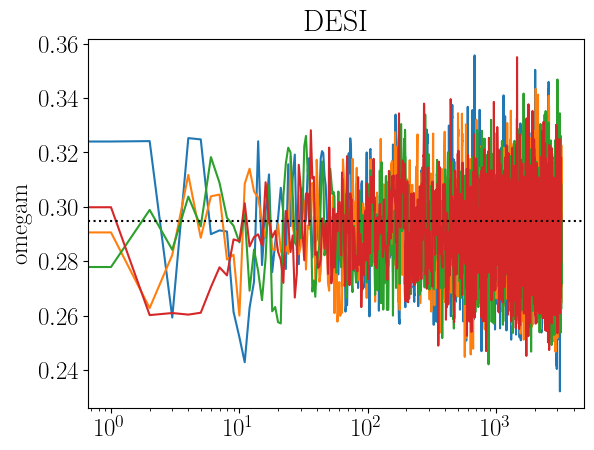

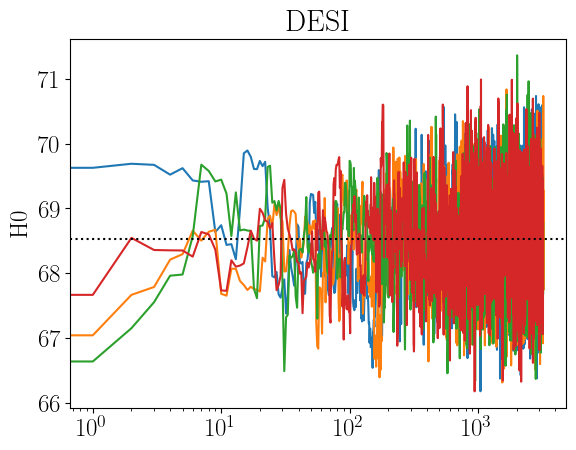

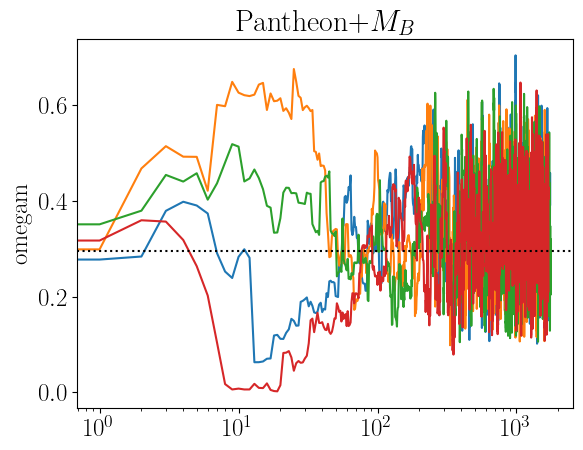

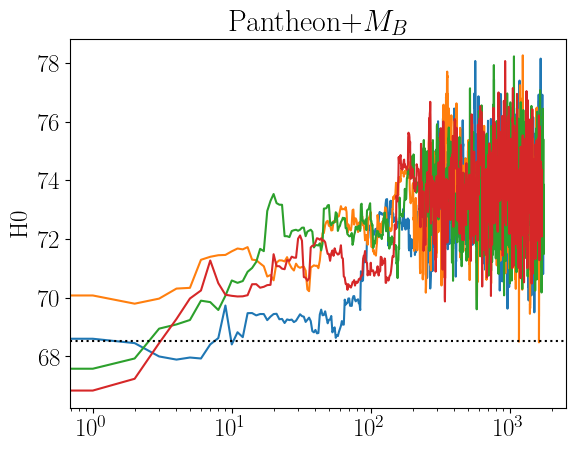

In [5]:
analyzed_results = {model: {name: analyze_results(name,resdict) for name,resdict in model_dict.items()} 
                    for model,model_dict in results.items()}

# Parameter plots

## General

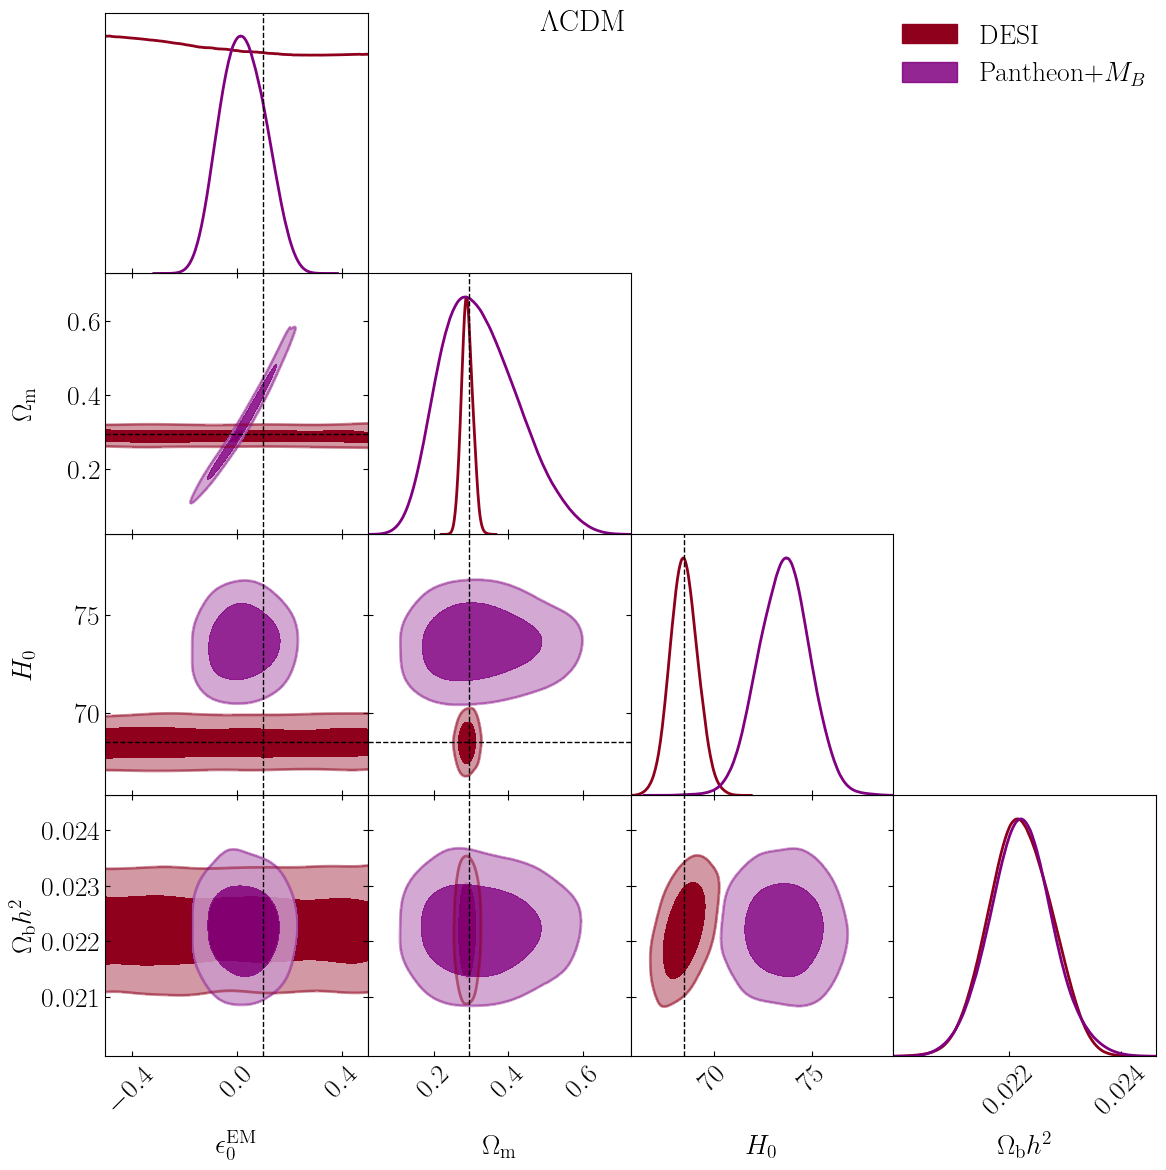

In [6]:
for model,model_dict in analyzed_results.items():
    g = plots.get_subplot_plotter(subplot_size=1,width_inch=12, scaling=False)
    g.settings.figure_legend_frame = False
    g.settings.axes_fontsize=20
    g.settings.axes_labelsize=20
    g.settings.legend_fontsize=20
    g.settings.axis_marker_color = 'black'
    g.settings.axis_marker_ls = '--'
    g.settings.axis_marker_lw = 1
    g.settings.axis_tick_x_rotation = 45
    g.triangle_plot([result['MCsamples'] for result in model_dict.values()], 
        ['epsilon0_EM','omegam','H0','ombh2'],
        filled=[result['filled'] for result in model_dict.values()],
        legend_loc='upper right',
        legend_labels=[result for result in model_dict.keys()],
        contour_colors=[result['color'] for result in model_dict.values()],
        contour_lws=2,
        markers={k:v for k,v in DESI_LCDM.items()})    
    plt.suptitle(model)
    g.fig.align_ylabels()
    g.fig.align_xlabels();

## DDR

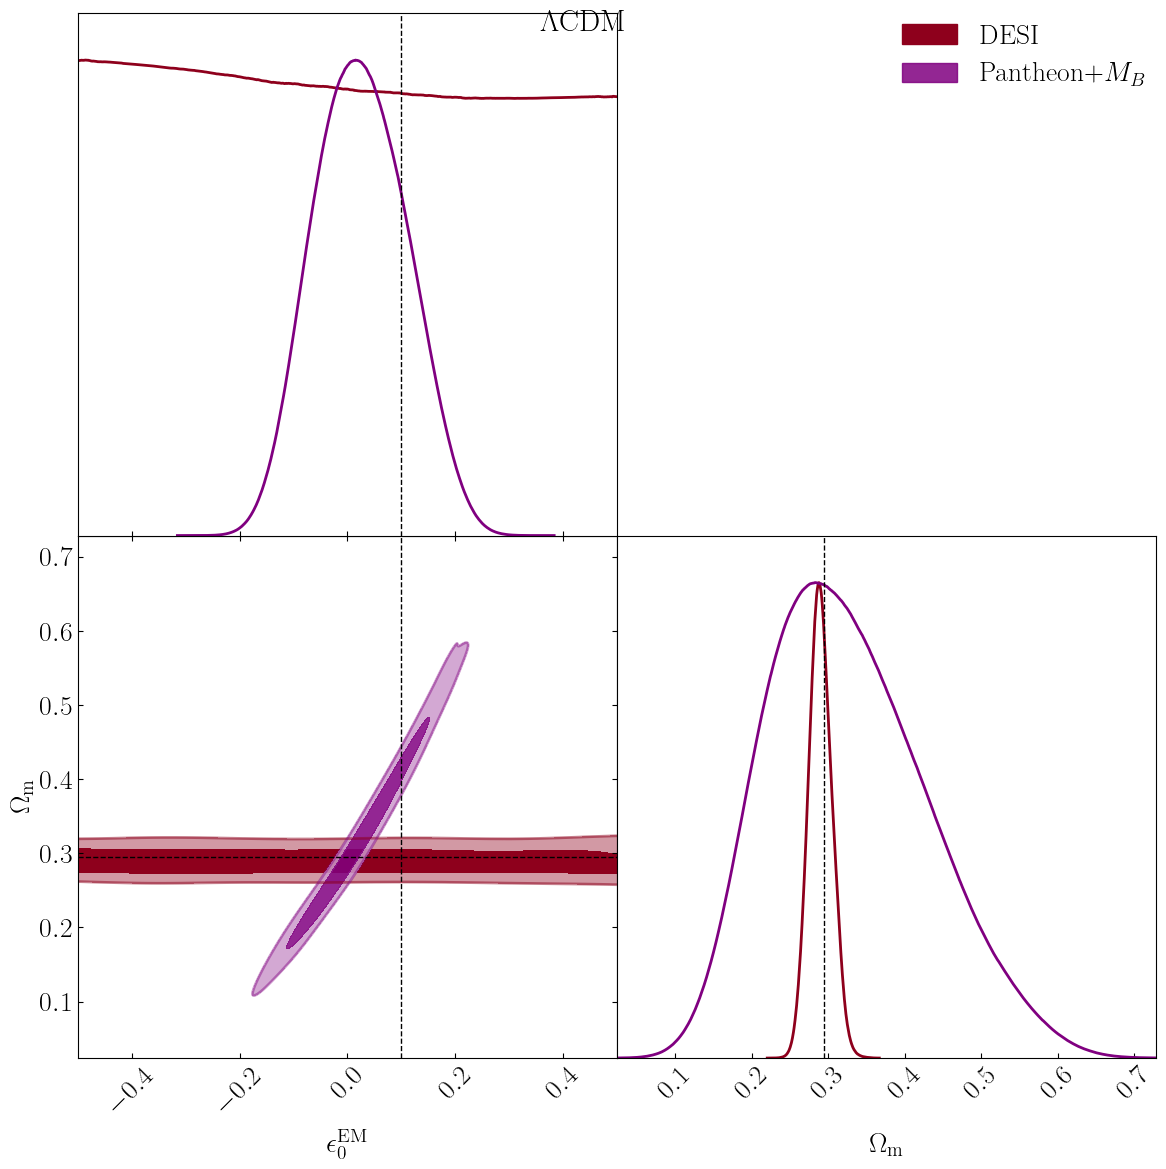

In [7]:
for model,model_dict in analyzed_results.items():
    g = plots.get_subplot_plotter(subplot_size=1,width_inch=12, scaling=False)
    g.settings.figure_legend_frame = False
    g.settings.axes_fontsize=20
    g.settings.axes_labelsize=20
    g.settings.legend_fontsize=20
    g.settings.axis_marker_color = 'black'
    g.settings.axis_marker_ls = '--'
    g.settings.axis_marker_lw = 1
    g.settings.axis_tick_x_rotation = 45
    g.triangle_plot([result['MCsamples'] for result in model_dict.values()], 
        ['epsilon0_EM','omegam'],
        filled=[result['filled'] for result in model_dict.values()],
        legend_loc='upper right',
        legend_labels=[result for result in model_dict.keys()],
        contour_colors=[result['color'] for result in model_dict.values()],
        contour_lws=2,
        markers={k:v for k,v in DESI_LCDM.items()})    
    plt.suptitle(model)
    g.fig.align_ylabels()
    g.fig.align_xlabels();

# Tension plots

## $H_0$

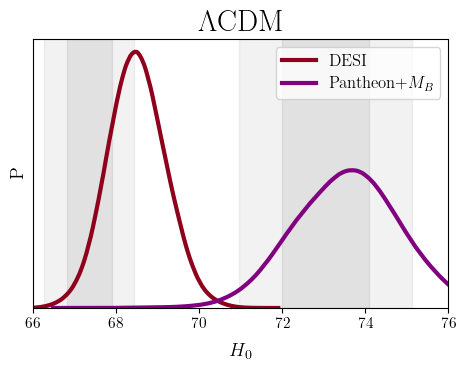

In [8]:
for model,model_dict in analyzed_results.items():
    g = plots.get_single_plotter(width_inch=5)
    g.plot_1d([result['MCsamples'] for result in model_dict.values()],'H0',
              colors=[result['color'] for result in model_dict.values()], 
              normalized=True,
              lims=[66,76],
              lws=3)
    g.add_x_bands(73.04, 1.04)
    g.add_x_bands(67.36, 0.54)
    g.add_legend([result for result in model_dict.keys()])
    plt.title(model)

## $M_B$

In [9]:
for model,model_dict in analyzed_results.items():
    if r'DESI+Pantheon' in model_dict:
        g = plots.get_single_plotter(width_inch=5)
        g.plot_1d([model_dict[r'DESI+Pantheon']['MCsamples']],'MB',
                  colors=[model_dict[r'DESI+Pantheon']['color']], 
                  normalized=True,
                  lims=[-19.5,-19.1],
                  lws=3)
        g.add_x_bands(-19.2435 ,0.0373)
        plt.title(model)

In [10]:
for model,model_dict in analyzed_results.items():
     if r'ET' in model_dict:
        g = plots.get_single_plotter(width_inch=5)
        g.plot_1d([model_dict[r'ET']['MCsamples']],'epsilon0_GW',
                  colors=[model_dict[r'ET']['color']], 
                  normalized=True,
                  lims=[-0.2,0.3],
                  lws=3)
        g.add_x_bands(-0.1 ,0.0373)
        plt.title(model)

# Theory plots

## load data

In [11]:
datalist = []
dataset_SN = np.load(SN_data+'.npy',allow_pickle=True).item()
datalist.append(pd.DataFrame.from_dict({r'$z$': dataset_SN['z'],
                                        r'$m_B(z)$': dataset_SN['value'],
                                        r'error': [np.sqrt(var) for var in np.diag(dataset_SN['covmat'])]}))

dataset_DH = np.load(BAO_data+'_DH.npy',allow_pickle=True).item()
datalist.append(pd.DataFrame.from_dict({r'$z$': dataset_DH['z'],
                                        r'$d_H(z)$': dataset_DH['value'],
                                        r'error': [var for var in dataset_DH['covmat']]}))

dataset_DM = np.load(BAO_data+'_DM.npy',allow_pickle=True).item()
datalist.append(pd.DataFrame.from_dict({r'$z$': dataset_DM['z'],
                                        r'$d_M(z)$': dataset_DM['value'],
                                        r'error': [var for var in dataset_DM['covmat']]}))

dataset_DV = np.load(BAO_data+'_DV.npy',allow_pickle=True).item()
datalist.append(pd.DataFrame.from_dict({r'$z$': dataset_DV['z'],
                                        r'$d_V(z)$': dataset_DV['value'],
                                        r'error': [np.sqrt(var) for var in np.diag(dataset_DV['covmat'])]}))

dataset_GW = np.load(GW_data+'.npy',allow_pickle=True).item()

datalist.append(pd.DataFrame.from_dict({r'$z$': dataset_GW['z'],
                                        r'$h_GW$': dataset_GW['h_GW'],
                                        r'error': [np.sqrt(var) for var in np.diag(dataset_GW['covmat'])]}))



data = pd.concat(datalist,ignore_index=True)

KeyError: 'value'

## pack theory

In [ ]:
functions = {'DH': r'$d_H(z)$',
             'DL_EM': r'$d_L^{\rm em}(z)$',
             'DL_GW': r'$d_L^{\rm gw}(z)$',
             'DM': r'$d_M(z)$',
             'DV': r'$d_V(z)$',
             'h_GW': r'$h_GW$',
             'eta_EM': r'$\eta^{\rm em}(z)$',
             'eta_GW': r'$\eta^{\rm gw}(z)$',
             'mB': r'$m_B(z)$'}



for model, model_dict in analyzed_results.items():
    full_results = []
    
    for name,results in model_dict.items():
        theory = results['theory']
        theory_df = pd.DataFrame.from_dict({r'$z$': zplot}|{label: getattr(theory,func)(zplot) 
                                                         for func,label in functions.items()})
        
        theory_df['Case']  = name
        theory_df['color'] = results['color']
        
        full_results.append(theory_df)
        
    model_dict['Theory'] = pd.concat(full_results,ignore_index=True)

In [ ]:
for model, model_dict in analyzed_results.items():
    for func in functions.values():
        
        plt.figure()
        plt.title(model)
        sb.lineplot(model_dict['Theory'],x=r'$z$',y=func,
                    hue='Case',palette=list(model_dict['Theory']['color'].unique()))
        if func in data.columns:
            
            dataplot = data[[r'$z$',func,'error']].dropna(axis='index')
            plt.errorbar(dataplot[r'$z$'],dataplot[func],yerr=dataplot['error'],
                         ls='',color='black',marker='*')